In [99]:
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import os
import sys
import numpy as np
import ast
from scipy.optimize import curve_fit, nnls
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError, pauli_error, depolarizing_error, thermal_relaxation_error)
from qiskit.quantum_info import Pauli, pauli_basis, SuperOp, PTM, Operator

home_folder = os.getcwd()
is_pyquil = "pyquil_program" in home_folder
if is_pyquil and "AutomatedPERTools" in home_folder:
	raise Exception("Both folders?")
i = 0
while not "pauli_lindblad_per" in os.listdir(home_folder):
	home_folder = os.path.dirname(home_folder)
	i+=1
	if i == 50:
		raise Exception("pauli_lindblad_per not found. Please make sure it is in this or a parent folder")
sys.path.append(os.path.join(home_folder, "pauli_lindblad_per"))
import pickle

print(home_folder)

e:\OneDrive\Dokumente\Uni_kram\Masterarbeit\AutomatedPERTools


In [100]:
# Determine Folders
main_folder_path = "tutorial_notebooks/testrun/runs".split('/')
main_folder = ""
for segment in main_folder_path:
    main_folder = os.path.join(main_folder, segment)
folders = [f for f in os.listdir(os.path.join(home_folder, main_folder)) if os.path.isdir(os.path.join(os.path.join(home_folder, main_folder), f))]
#filtered_folders = [f for f in folders if "False_16_100_100_1024_4_False_True_{0, 1, 2, 3}_[2, 4, 8]_circuits_make_initial_Circuit_False__generic_backend_4" in f]

filtered_folders = [st for st in folders if st.startswith("1000")]
                    #decipher_name(f)["pntsamples"] == 64 and 
                    #"False_16_100_100_1024_3_False_True_{0, 1}_[2, 4, 8, 16]__CNOT_LAYER1" in f]
#filtered_folders = sorted(filtered_folders, key=lambda item: decipher_name(item)["pntsinglesamples"])
for folder in filtered_folders:
    print(folder)

1000_[0.25, 0.5, 0.75, 1.0, 2.0]
1000_[0.25, 0.5, 0.75, 1.0]
1000_[0.25, 0.5, 1.0, 2.0, 3.0]
1000_[0.25, 0.5, 1.0, 2.0]
1000_[0.25, 0.5, 1.0]
1000_[0.5, 0.75, 1.0, 2.0, 3.0]
1000_[0.5, 1.0, 2.0, 3.0]
1000_[0.5, 1.0, 2.0]


In [101]:
rel_values_all = []
rel_errors_all = []
for folder in filtered_folders:
	folderpath = os.path.join(os.path.join(home_folder, main_folder),folder)
	rel_values = []
	rel_errors = []
	for file in os.listdir(os.path.join(folderpath, "rel_value")):
		with open(os.path.join(os.path.join(folderpath, "rel_value"), file), "rb") as f:
			rel_values.append(pickle.load(f))
			#print(rel_values[-1])
		with open(os.path.join(os.path.join(folderpath, "rel_error"), file), "rb") as f:
			rel_errors.append(pickle.load(f))
	rel_values_all.append(rel_values)
	rel_errors_all.append(rel_errors)
	#print()


In [102]:
aver_values_all = []
aver_values_err_all = []
aver_errors_all = []
aver_errors_err_all = []
for i, folder in enumerate(filtered_folders):
	aver_values = []
	aver_values_err = []
	aver_errors = []
	aver_errors_err = []
	for k in range(len(rel_values_all[i][0])):
		average_val = 0
		vals = []
		average_err = 0
		errs = []
		for j, val in enumerate(rel_values_all[i]):
			average_val+=rel_values_all[i][j][k]
			vals.append(rel_values_all[i][j][k])
			average_err+=rel_errors_all[i][j][k]
			errs.append(rel_errors_all[i][j][k])
		average_val /= len(rel_values_all[i])
		average_err /= len(rel_values_all[i])
		aver_values.append(average_val)
		aver_values_err.append(np.std(vals))
		aver_errors.append(average_err)
		aver_errors_err.append(np.std(errs))
	aver_values_all.append(aver_values)
	aver_values_err_all.append(aver_values_err)
	aver_errors_all.append(aver_errors)
	aver_errors_err_all.append(aver_errors_err)

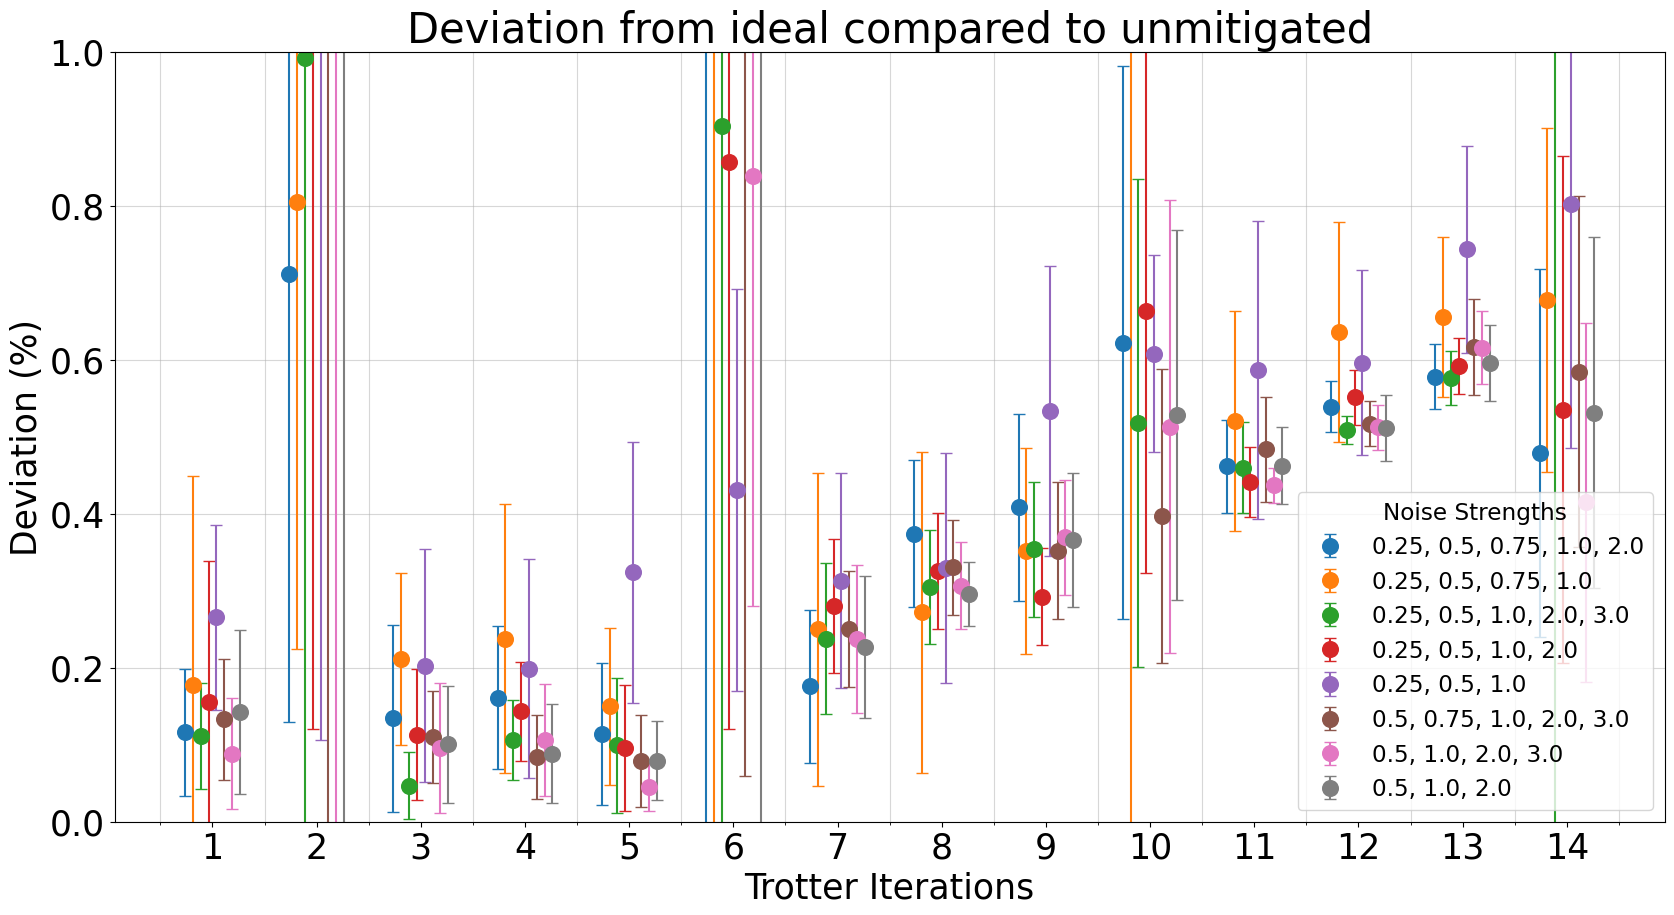

In [103]:
fontsize =25
foldernames = [val[6:len(val)-1] for val in filtered_folders]
def plot_values(str):
	fig, ax = plt.subplots(figsize=(20, 10))
	x_values = [i+1 for i in range(len(rel_values_all[0][0]))]
	for i, folder in enumerate(foldernames):
		ax.errorbar([j-(0.075*(len(foldernames)-1))/2+0.075*i for j in x_values], aver_values_all[i], aver_values_err_all[i], label=folder, marker="o", linestyle="", capsize=4, markersize=9*fontsize/20)
	ax.set_ylim(0, 1)#1#15#9
	ax.grid(True, zorder=0.5, axis='y', alpha=0.5)
	ax.grid(True, zorder=0.5, axis='x', alpha=0.5, which="minor")
	ax.set_xticks(x_values)
	ax.set_xticks([i+0.5 for i in x_values]+[0.5], minor=True)
	ax.set_xlabel("Trotter Iterations", fontsize=fontsize)
	ax.set_ylabel("Deviation (%)", fontsize=fontsize)
	ax.tick_params(axis='both', which='major', labelsize=fontsize)
	#ax.set_yticklabels([1,0.8,0.6,0.4,0.2,0], fontsize=fontsize, rotation=20)
	plt.legend(fontsize=fontsize/1.5, title=str, title_fontsize=fontsize/1.5)
	plt.title("Deviation from ideal compared to unmitigated", fontsize=fontsize*1.2)
	plt.show()
plot_values("Noise Strengths")

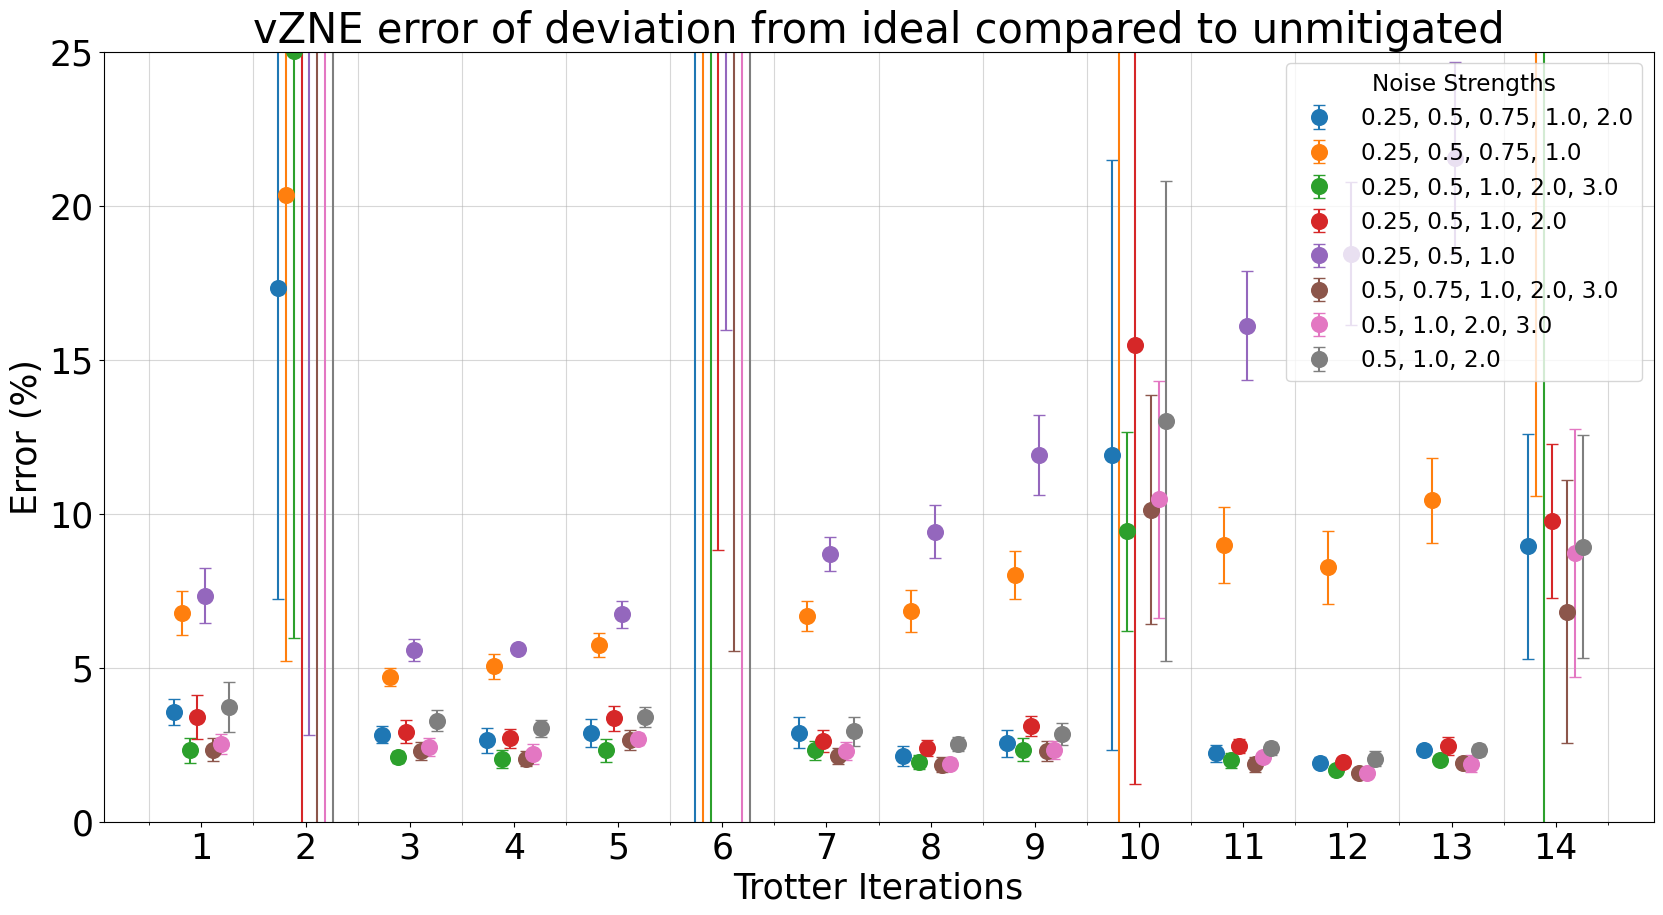

In [104]:
def plot_errors(str):
	fig, ax = plt.subplots(figsize=(20, 10))
	x_values = [i+1 for i in range(len(rel_values_all[0][0]))]
	for i, folder in enumerate(foldernames):
		ax.errorbar([j-(0.075*(len(foldernames)-1))/2+0.075*i for j in x_values], aver_errors_all[i], aver_errors_err_all[i], label=folder, marker="o", linestyle="", capsize=4, markersize=9*fontsize/20)
	ax.set_ylim(0, 25)#25#800#600
	ax.set_xticks(x_values)
	ax.set_xticks([i+0.5 for i in x_values]+[0.5], minor=True)
	ax.grid(True, zorder=0.5, axis='x', alpha=0.5, which="minor")
	ax.set_xlabel("Trotter Iterations", fontsize=fontsize)
	ax.set_ylabel("Error (%)", fontsize=fontsize)
	ax.tick_params(axis='both', which='major', labelsize=fontsize)
	ax.grid(True, zorder=0.5, axis='y', alpha=0.5)
	plt.legend(fontsize=fontsize/1.5, title=str, title_fontsize=fontsize/1.5)
	plt.title("vZNE error of deviation from ideal compared to unmitigated", fontsize=fontsize*1.2)
	plt.show()
plot_errors("Noise Strengths")

In [105]:
folder_average = []
folder_err_of_average = []
folder_average_err = []
folder_err_of_average_err = []
for i, folder in enumerate(foldernames):
	average = sum([val for j, val in enumerate(aver_values_all[i]) if j+1 not in [2,6,10,14]])/(len(aver_values_all[i])-1)
	err_of_average = sum([val for j, val in enumerate(aver_values_err_all[i]) if j+1 not in [2,6,10,14]])/(len(aver_values_err_all[i])-1)
	average_err = sum([val for j, val in enumerate(aver_errors_all[i]) if j+1 not in [2,6,10,14]])/(len(aver_errors_all[i])-1)
	err_of_average_err = sum([val for j, val in enumerate(aver_errors_err_all[i]) if j+1 not in [2,6,10,14]])/(len(aver_errors_err_all[i])-1)
	folder_average.append(average)
	folder_err_of_average.append(err_of_average)
	folder_average_err.append(average_err)
	folder_err_of_average_err.append(err_of_average_err)
#print(folder_average)
# Sort array1 and reorder array2 accordingly
sorted_average, sorted_err_of_average, sorted_average_err, sorted_err_of_average_err, sorted_foldernames = zip(*sorted(zip(folder_average, folder_err_of_average, folder_average_err, folder_err_of_average_err, foldernames), reverse=True))

# Convert back to lists (optional)
sorted_average = list(sorted_average)
sorted_err_of_average = list(sorted_err_of_average)
sorted_average_err = list(sorted_average_err)
sorted_err_of_average_err = list(sorted_err_of_average_err)
sorted_foldernames = list(sorted_foldernames)

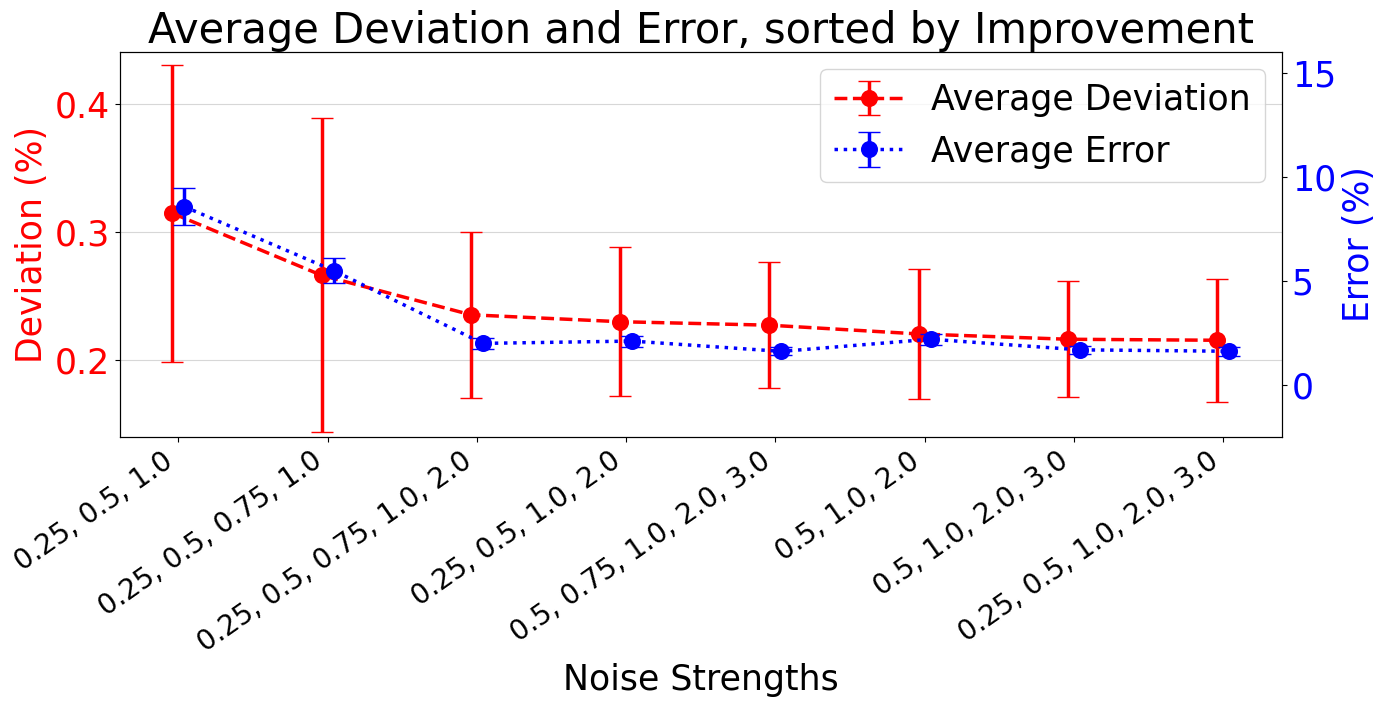

In [106]:
fig, ax1 = plt.subplots(figsize=(15, 5))
ax2 = ax1.twinx()
x_values = [i+1 for i in range(len(folder_average))]
ax1.tick_params(axis='both', which='major', labelsize=fontsize)
ax2.tick_params(axis='both', which='major', labelsize=fontsize)
line1 = ax1.errorbar([i-0.04 for i in x_values], sorted_average, yerr=sorted_err_of_average, label="Average Deviation", marker="o", color="r", linestyle="--", linewidth=2*fontsize/20, markersize=9*fontsize/20, capsize=8)
line2 = ax2.errorbar([i+0.04 for i in x_values], sorted_average_err, yerr=sorted_err_of_average_err, label="Average Error", marker="o", color="b", linestyle="dotted", linewidth=2*fontsize/20, markersize=9*fontsize/20, capsize=8)
ax1.set_ylim(min(sorted_average)*0.65, max(sorted_average)*1.4)
ax2.set_ylim(-2.5, 16)
ax1.set_xticks(x_values)
ax1.set_xticklabels(sorted_foldernames, fontsize=fontsize*0.8, rotation=35, ha="right")
ax1.grid(True, zorder=0.5, axis='y', alpha=0.5)
ax1.tick_params(axis='y', labelcolor='r')
ax2.tick_params(axis='y', labelcolor='b')

ax1.set_xlabel("Noise Strengths", fontsize=fontsize)
ax1.set_ylabel("Deviation (%)", fontsize=fontsize, color='r')
ax2.set_ylabel("Error (%)", fontsize=fontsize, color='b')
plt.title("Average Deviation and Error, sorted by Improvement", fontsize=fontsize*1.2)
plt.legend([line1, line2], [line1.get_label(), line2.get_label()], fontsize=fontsize)
plt.show()

# Numbers


In [107]:
# Determine Folders
main_folder_path = "tutorial_notebooks/testrun/runs".split('/')
main_folder = ""
for segment in main_folder_path:
    main_folder = os.path.join(main_folder, segment)
folders = [f for f in os.listdir(os.path.join(home_folder, main_folder)) if os.path.isdir(os.path.join(os.path.join(home_folder, main_folder), f))]
#filtered_folders = [f for f in folders if "False_16_100_100_1024_4_False_True_{0, 1, 2, 3}_[2, 4, 8]_circuits_make_initial_Circuit_False__generic_backend_4" in f]

filtered_folders = [st for st in folders if "[0.5, 1.0, 2.0]" in st]

filtered_folders = sorted(filtered_folders, key=lambda item: int(item.split("_")[0]))
for folder in filtered_folders:
    print(folder)

100_[0.5, 1.0, 2.0]
200_[0.5, 1.0, 2.0]
500_[0.5, 1.0, 2.0]
1000_[0.5, 1.0, 2.0]
2000_[0.5, 1.0, 2.0]
4000_[0.5, 1.0, 2.0]


In [108]:
rel_values_all = []
rel_errors_all = []
for folder in filtered_folders:
	folderpath = os.path.join(os.path.join(home_folder, main_folder),folder)
	rel_values = []
	rel_errors = []
	for file in os.listdir(os.path.join(folderpath, "rel_value")):
		with open(os.path.join(os.path.join(folderpath, "rel_value"), file), "rb") as f:
			rel_values.append(pickle.load(f))
		with open(os.path.join(os.path.join(folderpath, "rel_error"), file), "rb") as f:
			rel_errors.append(pickle.load(f))
	rel_values_all.append(rel_values)
	rel_errors_all.append(rel_errors)


In [109]:
aver_values_all = []
aver_values_err_all = []
aver_errors_all = []
aver_errors_err_all = []
for i, folder in enumerate(filtered_folders):
	aver_values = []
	aver_values_err = []
	aver_errors = []
	aver_errors_err = []
	for k in range(len(rel_values_all[i][0])):
		average_val = 0
		vals = []
		average_err = 0
		errs = []
		for j, val in enumerate(rel_values_all[i]):
			average_val+=rel_values_all[i][j][k]
			vals.append(rel_values_all[i][j][k])
			average_err+=rel_errors_all[i][j][k]
			errs.append(rel_errors_all[i][j][k])
		average_val /= len(rel_values_all[i])
		average_err /= len(rel_values_all[i])
		aver_values.append(average_val)
		aver_values_err.append(np.std(vals))
		aver_errors.append(average_err)
		aver_errors_err.append(np.std(errs))
	aver_values_all.append(aver_values)
	aver_values_err_all.append(aver_values_err)
	aver_errors_all.append(aver_errors)
	aver_errors_err_all.append(aver_errors_err)

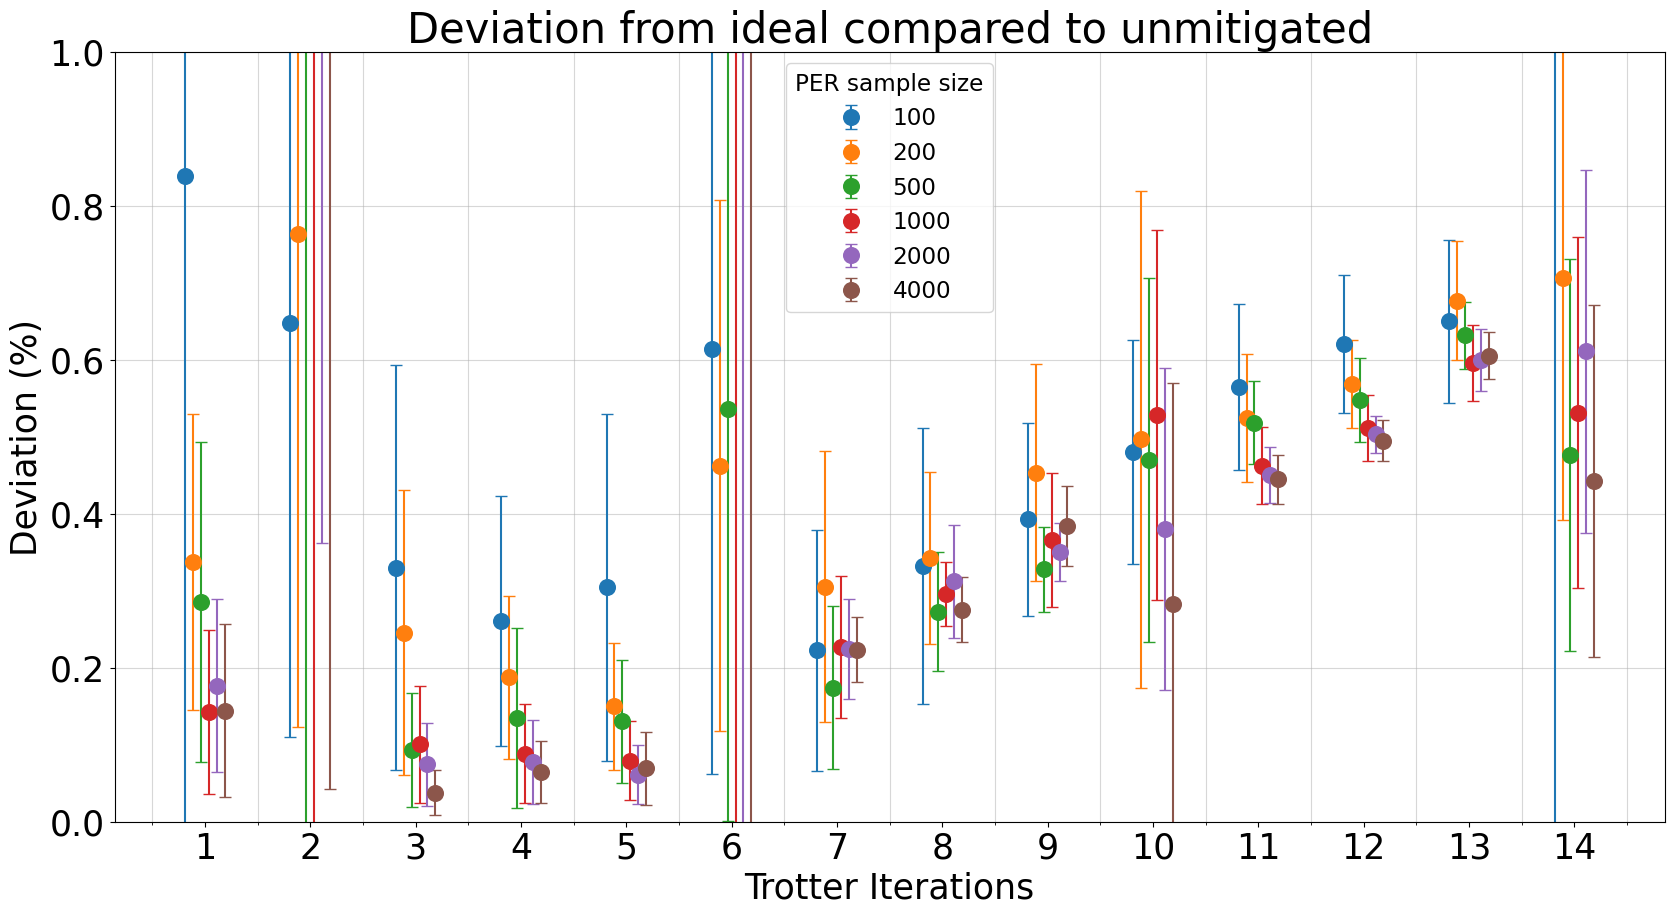

In [110]:
fontsize =25
foldernames = [val.split("_")[0] for val in filtered_folders]
plot_values("PER sample size")

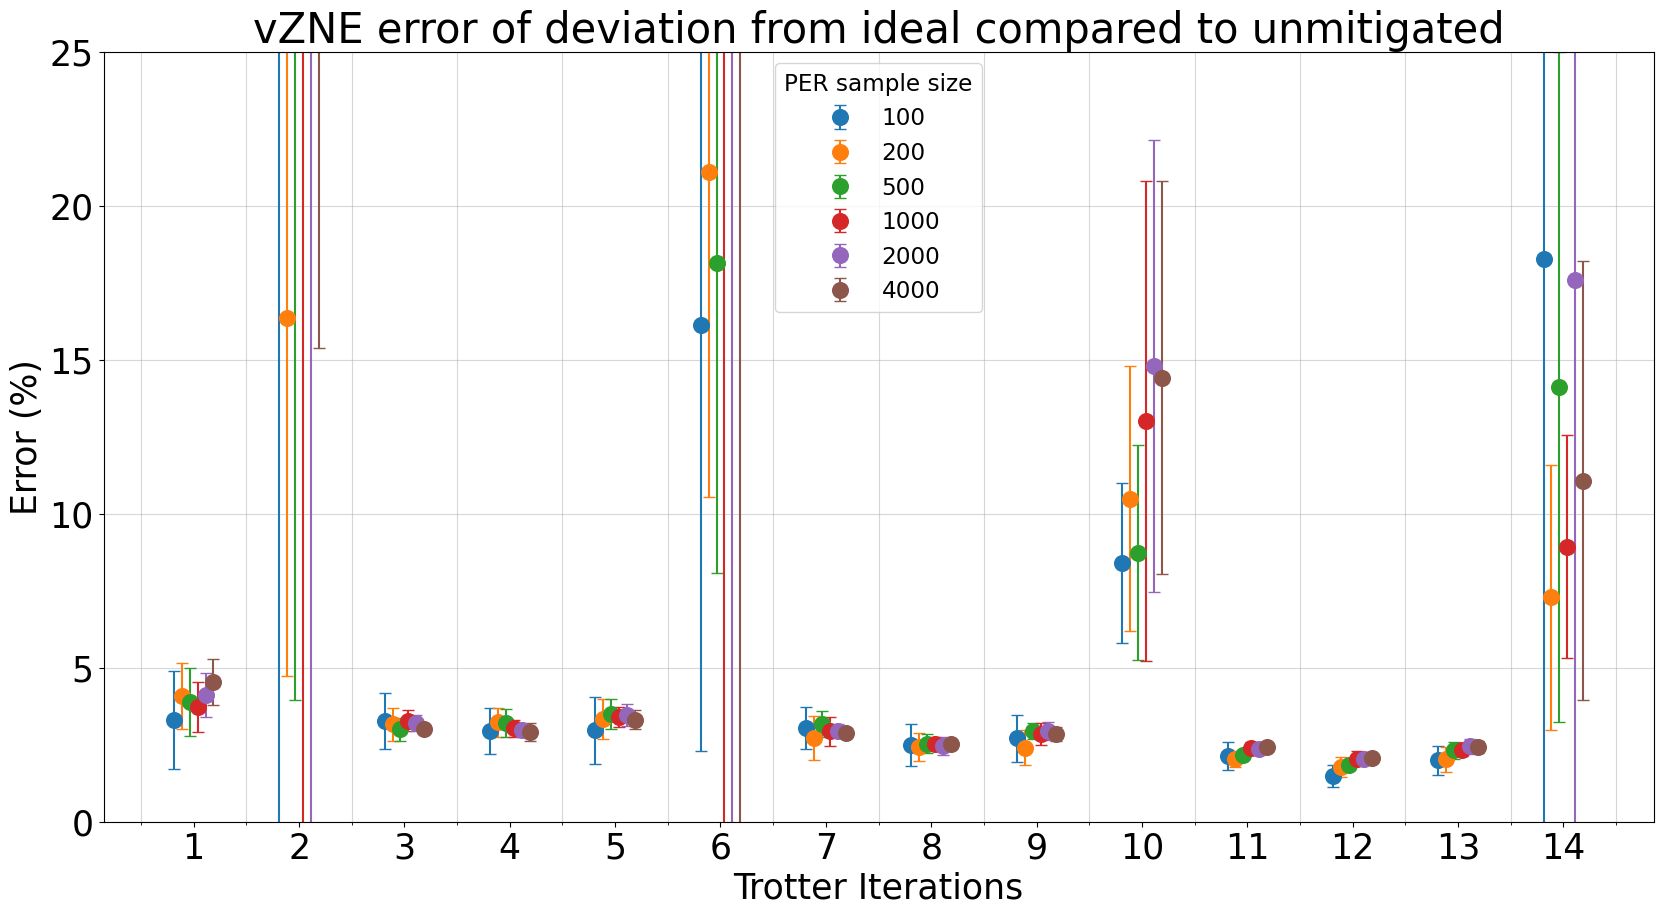

In [111]:
plot_errors("PER sample size")

In [112]:
folder_average = []
folder_err_of_average = []
folder_average_err = []
folder_err_of_average_err = []
for i, folder in enumerate(foldernames):
	average = sum([val for j, val in enumerate(aver_values_all[i]) if j+1 not in [2,6,10,14]])/(len(aver_values_all[i])-1)
	err_of_average = sum([val for j, val in enumerate(aver_values_err_all[i]) if j+1 not in [2,6,10,14]])/(len(aver_values_err_all[i])-1)
	average_err = sum([val for j, val in enumerate(aver_errors_all[i]) if j+1 not in [2,6,10,14]])/(len(aver_errors_all[i])-1)
	err_of_average_err = sum([val for j, val in enumerate(aver_errors_err_all[i]) if j+1 not in [2,6,10,14]])/(len(aver_errors_err_all[i])-1)
	folder_average.append(average)
	folder_err_of_average.append(err_of_average)
	folder_average_err.append(average_err)
	folder_err_of_average_err.append(err_of_average_err)

In [113]:
foldernames

['100', '200', '500', '1000', '2000', '4000']

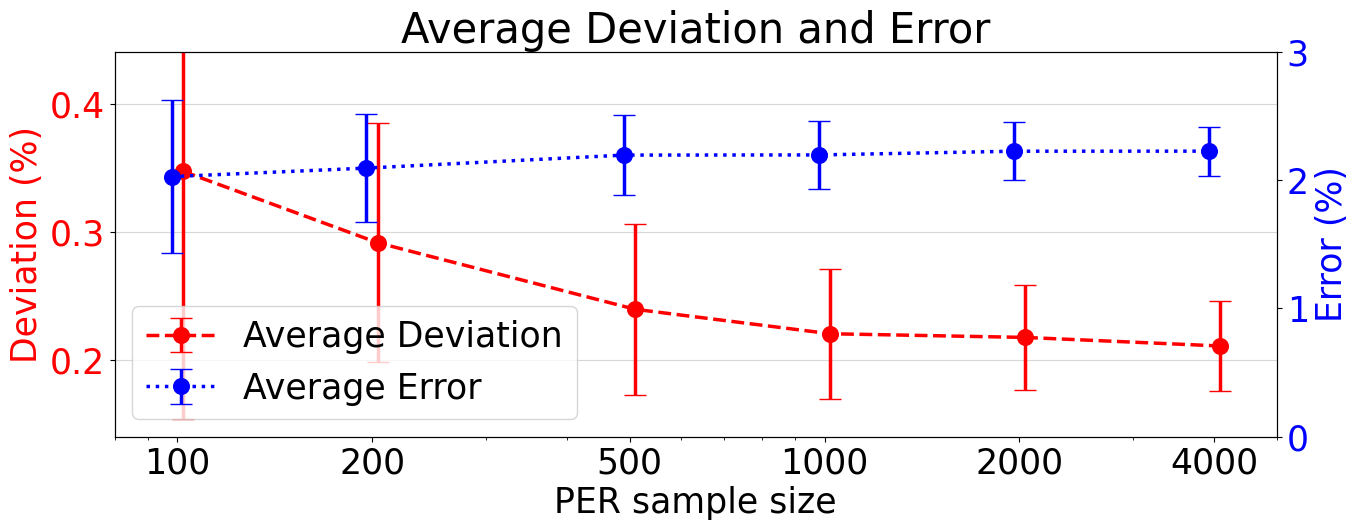

In [114]:
fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.set_xscale('log')
ax2 = ax1.twinx()
x_values = [int(i) for i in foldernames]#[i+1 for i in range(len(folder_average))]
ax1.tick_params(axis='both', which='major', labelsize=fontsize)
ax2.tick_params(axis='both', which='major', labelsize=fontsize)
line1 = ax1.errorbar([i*1.02 for i in x_values], folder_average, yerr=folder_err_of_average, label="Average Deviation", marker="o", color="r", linestyle="--", linewidth=2*fontsize/20, markersize=9*fontsize/20, capsize=8)
line2 = ax2.errorbar([i*0.98 for i in x_values], folder_average_err, yerr=folder_err_of_average_err, label="Average Error", marker="o", color="b", linestyle="dotted", linewidth=2*fontsize/20, markersize=9*fontsize/20, capsize=8)
ax1.set_ylim(min(sorted_average)*0.65, max(sorted_average)*1.4)
ax1.set_xlim(80, 5000)
ax2.set_ylim(0, 3)
ax1.set_xticks(x_values)
ax1.set_xticklabels(foldernames, fontsize=fontsize, rotation=0)
ax1.grid(True, zorder=0.5, axis='y', alpha=0.5)
ax1.tick_params(axis='y', labelcolor='r')
ax2.tick_params(axis='y', labelcolor='b')

ax1.set_xlabel("PER sample size", fontsize=fontsize)
ax1.set_ylabel("Deviation (%)", fontsize=fontsize, color='r')
ax2.set_ylabel("Error (%)", fontsize=fontsize, color='b')
plt.title("Average Deviation and Error", fontsize=fontsize*1.2)
plt.legend([line1, line2], [line1.get_label(), line2.get_label()], fontsize=fontsize)
plt.show()

In [115]:
filtered_folders

['100_[0.5, 1.0, 2.0]',
 '200_[0.5, 1.0, 2.0]',
 '500_[0.5, 1.0, 2.0]',
 '1000_[0.5, 1.0, 2.0]',
 '2000_[0.5, 1.0, 2.0]',
 '4000_[0.5, 1.0, 2.0]']

In [116]:
rel_values_all = []
rel_errors_all = []
folder = "1000_[0.5, 1.0, 2.0]"

folderpath = os.path.join(os.path.join(home_folder, main_folder),folder)
res_array = []
noisyresult_array = []
results_array = []
for file in os.listdir(os.path.join(folderpath, "res")):
	with open(os.path.join(os.path.join(folderpath, "res"), file), "rb") as f:
		res_array.append(pickle.load(f))
	with open(os.path.join(os.path.join(folderpath, "noisyresult"), file), "rb") as f:
		noisyresult_array.append(pickle.load(f))
	with open(os.path.join(os.path.join(folderpath, "results"), file), "rb") as f:
		results_array.append(pickle.load(f))
res = [0 for _ in range(len(res_array[0]))]
noisyresult = [0 for _ in range(len(res_array[0]))]
results = [0 for _ in range(len(res_array[0]))]
res_err = []
noisyresult_err = []
results_err = []

for j in range(len(res_array[0])):
	temp = []
	for i in range(len(res_array)):
		temp.append(res_array[i][j])
		res[j]+=res_array[i][j]
	res[j]/=len(res_array)
	res_err.append(np.std(temp))
	
for j in range(len(noisyresult_array[0])):
	temp = []
	for i in range(len(noisyresult_array)):
		temp.append(noisyresult_array[i][j])
		noisyresult[j]+=noisyresult_array[i][j]
	noisyresult[j]/=len(noisyresult_array)
	noisyresult_err.append(np.std(temp))

for j in range(len(results_array[0])):
	temp = []
	for i in range(len(results_array)):
		temp.append(results_array[i][j])
		results[j]+=results_array[i][j]
	results[j]/=len(results_array)
	results_err.append(np.std(temp))


def return_trimmed(arr):
	return arr[0:1]+arr[2:5]+arr[6:9]+arr[10:13]
print(res)
res = return_trimmed(res)
noisyresult = return_trimmed(noisyresult)
results = return_trimmed(results)
def give_propper_under(i,j):
	return i
	return (i-(2*max(i-j,0)))

[0.6982421875, -0.02216796875, -0.713232421875, -0.958642578125, -0.631201171875, 0.061962890625, 0.665283203125, 0.842431640625, 0.5072265625, -0.087646484375, -0.571337890625, -0.672998046875, -0.392578125, 0.094921875]


8.503554455716678 0.494814225735965
3.2879298582778387 0.31369920431124126


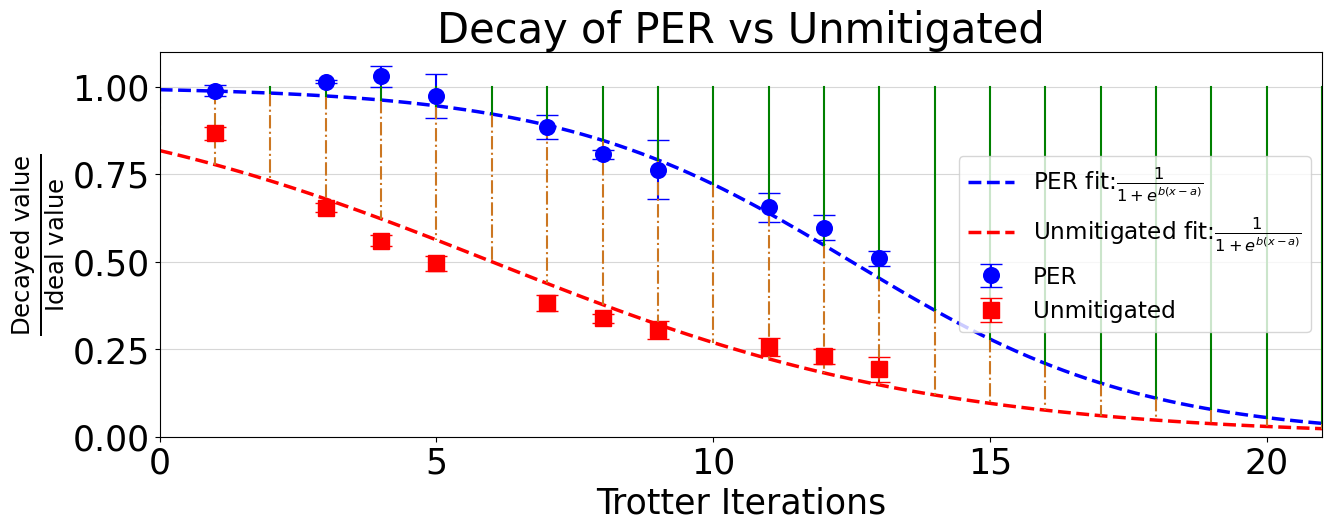

In [117]:
fig, ax = plt.subplots(figsize=(15, 5))
x_values_for_plot = return_trimmed([i+1 for i in range(14)])
#x_values = [i+1 for i in range(14)]

ax.errorbar(x_values_for_plot, [give_propper_under(abs(i),abs(j))/abs(j) for i,j in zip(results,res)], yerr=[give_propper_under(abs(i),abs(j))/abs(j) for i,j in zip(results_err,res)], marker="o", linestyle="", markersize=9*fontsize/20, color='b', label="PER", capsize=8)
x_values = ([i for i in range(22)])
xlin = np.linspace(min(x_values), max(x_values), max((max(x_values)-min(x_values))*2,100))

fitfunc = lambda x,a,b: (1/(1+np.exp(b*(x-a))))#a*np.exp(x*b)
popt, pcov = curve_fit(fitfunc, [val for val in x_values[0:len(results)-1]], [give_propper_under(abs(i),abs(j))/abs(j) for i,j in zip(results[0:-1],res[0:-1])], p0=[12,0.4])
a, b = popt
a1,b1 = 12.5,0.38
print(a,b)
ax.plot(xlin, [(1/(1+np.exp(b1*(x-a1))))for x in xlin], color = 'b', linestyle="--", zorder=2,  label="PER fit:$\\frac{1}{1+e^{b(x-a)}}$", linewidth=2*fontsize/20)
#plt.plot(xlin, [1/(1+np.exp(0.4*(x-12))) for x in xlin], color = 'g', linestyle="--", zorder=2,  label="Fit:$a x^b+c$ ", linewidth=2*fontsize/20)

ax.errorbar(x_values_for_plot, [i/j for i,j in zip(noisyresult,res)], yerr=[give_propper_under(abs(i),abs(j))/abs(j) for i,j in zip(noisyresult_err,res)], marker="s", linestyle="", markersize=9*fontsize/20, color='r', label="Unmitigated", capsize=8)
##
popt, pcov = curve_fit(fitfunc, [val for val in x_values[0:len(noisyresult)]], [i/j for i,j in zip(noisyresult,res)], p0=[1, -0.60482289908855247])
a, b = popt
a2,b2 = 6,0.25
print(a,b)
ax.plot(xlin, [(1/(1+np.exp(b2*(x-a2)))) for x in xlin], color = 'r', linestyle="--", zorder=2,  label="Unmitigated fit:$\\frac{1}{1+e^{b(x-a)}}$", linewidth=2*fontsize/20)

for x in range(0, len(x_values), 1):  # Adjust step size for density
	#x+=0.01
	plt.plot([x, x], [(1/(1+np.exp(b1*(x-a1)))), (1/(1+np.exp(b2*(x-a2))))], color='#CC7722', alpha=1, linestyle="-.")
	plt.plot([x, x], [(1/(1+np.exp(b1*(x-a1)))), 1], color='g', alpha=1)

#ax.plot(x_values, [abs(i) for i in results], marker="o", linestyle="", markersize=9*fontsize/20)
#ax.plot(x_values, [abs(i) for i in noisyresult], marker="o", linestyle="", markersize=9*fontsize/20)
ax.set_ylim(0, 1.1)#25#800#600
ax.set_xlim(0,max(x_values))
ax.set_xticks([0,5,10,15,20])
#ax.set_xticks([i+0.5 for i in x_values]+[0.5], minor=True)
ax.grid(True, zorder=0.5, axis='x', alpha=0.5, which="minor")
ax.set_xlabel("Trotter Iterations", fontsize=fontsize)
ax.set_ylabel("$\\frac{\\text{Decayed value}}{\\text{Ideal value}}$", fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.grid(True, zorder=0.5, axis='y', alpha=0.5)
plt.legend(fontsize=fontsize/1.5, title_fontsize=fontsize/1.5)
plt.title("Decay of PER vs Unmitigated", fontsize=fontsize*1.2)
plt.show()